In [ ]:
import time
from pathlib import Path

import cv2
import numpy as np
from numpy.typing import NDArray
from PIL import Image
from skimage import color, io
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.load_data import load_split

In [91]:
# root/
#   train/
#     REAL/
#     FAKE/
#   test/
#     REAL/
#     FAKE/

CIFAKE_ROOT = "data/"

# HOG params (for 32x32 images)
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)

# Gabor params
GABOR_FREQUENCIES = [0.2, 0.4]
GABOR_THETAS = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]


# Color hist params
COLOR_HIST_BINS = 16

type RGBImage_uint8 = NDArray[np.uint8]
type GrayImage_uint8 = NDArray[np.uint8]
type GrayImage_float32 = NDArray[np.float32]
type ColorImage_uint8 = NDArray[np.uint8]
type ColorImage_float32 = NDArray[np.float32]
type FeatureVector_float32 = NDArray[np.float32]

In [3]:
train_images, train_labels = load_split(CIFAKE_ROOT + "train/", library="pil")
len(train_images), train_images[0].shape, train_labels.shape

(100000, (32, 32, 3), (100000,))

In [4]:
test_images, test_labels = load_split(CIFAKE_ROOT + "test/", library="pil")
len(test_images), test_images[0].shape, test_labels.shape

(20000, (32, 32, 3), (20000,))

In [92]:
def extract_lbp(img: RGBImage_uint8, p: int, r: float, method: str) -> FeatureVector_float32:
    """Extract Local Binary Pattern (LBP) features from a grayscale image."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P=p, R=r, method=method)
    # uniform pattern -> P+2 bins
    n_bins = p + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)

In [94]:
LBP_P = 8  # Number of circularly symmetric neighbor set points.
LBP_R = 1  # Radius of circle.
# This create 3x3 neighborhood similar to filter masks.
LBP_METHOD = "uniform"  # Use uniform patterns.

In [101]:
lbp_features_list_train = []
for img in tqdm(train_images, desc="Extracting LBP features from train images"):
    lbp_features = extract_lbp(img, p=LBP_P, r=LBP_R, method=LBP_METHOD)
    lbp_features_list_train.append(lbp_features)

Extracting LBP features from train images: 100%|██████████| 100000/100000 [00:17<00:00, 5831.22it/s]


In [116]:
real_lbp_hist = np.array(lbp_features_list_train)[:50000].mean(axis=0)
fake_lbp_hist = np.array(lbp_features_list_train)[50000:].mean(axis=0)

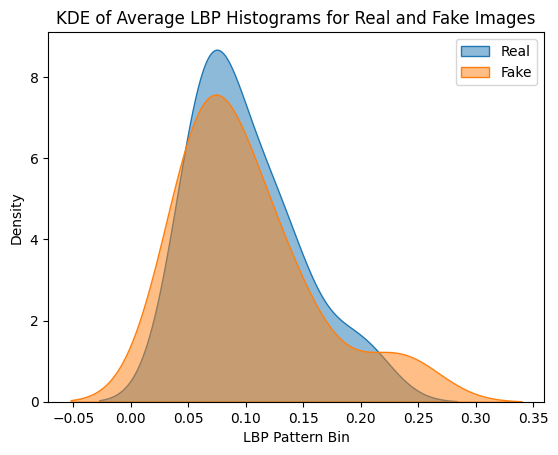

In [119]:
import seaborn as sns

sns.kdeplot(real_lbp_hist, label="Real", fill=True, alpha=0.5)
sns.kdeplot(fake_lbp_hist, label="Fake", fill=True, alpha=0.5)
plt.xlabel("LBP Pattern Bin")
plt.ylabel("Density")
plt.title("KDE of Average LBP Histograms for Real and Fake Images")
plt.legend()
plt.show()

In [ ]:
def extract_hog_feature(gray: GrayImage) -> FeatureVector:
    """Extract Histogram of Oriented Gradients (HOG) features from a grayscale image."""
    feat = hog(
        gray,
        orientations=HOG_ORIENTATIONS,
        pixels_per_cell=HOG_PIXELS_PER_CELL,
        cells_per_block=HOG_CELLS_PER_BLOCK,
        block_norm="L2-Hys",
        feature_vector=True,
    )
    return feat.astype(np.float32)


def stats_from_subband(subband: NDArray[np.float32]) -> list[float]:
    """Compute [mean, std, energy] from a wavelet subband."""
    subband = subband.astype(np.float32)
    mean = subband.mean()
    std = subband.std()
    energy = np.sum(subband**2) / subband.size
    return [mean, std, energy]


def extract_gabor_stats(gray: GrayImage) -> FeatureVector:
    """For each (frequency, theta), compute Gabor response -> mean & std of magnitude."""
    feats = []
    gray_float = gray.astype(np.float32) / 255.0

    for freq in GABOR_FREQUENCIES:
        for theta in GABOR_THETAS:
            real, imag = gabor(gray_float, frequency=freq, theta=theta)
            mag = np.sqrt(real**2 + imag**2)
            feats.append(mag.mean())
            feats.append(mag.std())

    return np.array(feats, dtype=np.float32)


def extract_color_hist(rgb: ColorImage) -> FeatureVector:
    """Per-channel histogram, concatenated: 3 * COLOR_HIST_BINS dims."""
    feats = []
    for c in range(3):  # R,G,B
        channel = rgb[..., c].ravel()
        hist, _ = np.histogram(channel, bins=COLOR_HIST_BINS, range=(0, 255), density=True)
        feats.extend(hist)
    return np.array(feats, dtype=np.float32)


def compute_feature_groups(images: list[ColorImage]) -> dict[str, NDArray[np.float32]]:
    """Compute all feature groups for a list of images.

    images: list of RGB images
    returns: dict(feature_name -> np.array[num_samples, dim])
    """
    feature_names = ["lbp", "hog", "gabor", "color"]
    feats = {name: [] for name in feature_names}

    for img in tqdm(images, desc="Extracting features"):
        # convert to grayscale in [0, 255]
        gray = color.rgb2gray(img)
        gray = (gray * 255).astype(np.uint8)

        feats["lbp"].append(extract_lbp(gray))
        feats["hog"].append(extract_hog_feature(gray))
        # feats["wavelet"].append(extract_wavelet_stats(gray))
        feats["gabor"].append(extract_gabor_stats(gray))
        feats["color"].append(extract_color_hist(img))

    # stack
    for k in feats.keys():
        feats[k] = np.vstack(feats[k])

    return feats


def concat_feature_groups(feats_dict: dict[str, NDArray[np.float32]], group_names: list[str]) -> NDArray[np.float32]:
    """Concatenate selected feature groups horizontally.

    feats_dict: {name: np.array[num_samples, dim]}
    group_names: list of keys to concat
    """
    return np.hstack([feats_dict[name] for name in group_names])


# -----------------------------
# Training & evaluation
# -----------------------------


def run_experiment(
    x_train: NDArray[np.float32],
    y_train: NDArray[np.int_],
    x_test: NDArray[np.float32],
    y_test: NDArray[np.int_],
    name: str,
) -> None:
    """Train & evaluate logistic regression on given features."""
    print("\n" + "=" * 60)
    print(f"Experiment: {name}")
    print("=" * 60)

    clf = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression(max_iter=1000, n_jobs=-1))])

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred, digits=4))


# 19 minutes 38.9 seconds

In [159]:
# 1. Load data
train_dir = Path(CIFAKE_ROOT) / "train"
test_dir = Path(CIFAKE_ROOT) / "test"

print("Loading training images...")
train_images, y_train = load_split(train_dir)
print("Loading test images...")
test_images, y_test = load_split(test_dir)

# 2. Feature extraction (per group)
print("\nComputing TRAIN features...")
train_feats = compute_feature_groups(train_images)
print("\nComputing TEST features...")
test_feats = compute_feature_groups(test_images)

feature_groups = ["lbp", "hog", "gabor", "color"]

# 3. Single-feature experiments (each feature alone)
for fg in feature_groups:
    X_tr = train_feats[fg]
    X_te = test_feats[fg]
    run_experiment(X_tr, y_train, X_te, y_test, name=f"{fg.upper()} only")

# 4. All features combined
all_name = "+".join(fg.upper() for fg in feature_groups)
X_train_all = concat_feature_groups(train_feats, feature_groups)
X_test_all = concat_feature_groups(test_feats, feature_groups)
run_experiment(X_train_all, y_train, X_test_all, y_test, name=f"ALL: {all_name}")

# 5. Ablation: ALL minus one group
for drop_fg in feature_groups:
    keep_groups = [fg for fg in feature_groups if fg != drop_fg]
    name = f"ALL minus {drop_fg.upper()} ({'+'.join(kg.upper() for kg in keep_groups)})"
    X_tr = concat_feature_groups(train_feats, keep_groups)
    X_te = concat_feature_groups(test_feats, keep_groups)
    run_experiment(X_tr, y_train, X_te, y_test, name=name)


Loading training images...
Loading test images...

Computing TRAIN features...


Extracting features: 100%|██████████| 200/200 [00:01<00:00, 152.00it/s]



Computing TEST features...


Extracting features: 100%|██████████| 200/200 [00:01<00:00, 150.99it/s]



Experiment: LBP only
              precision    recall  f1-score   support

           0     0.6667    0.7000    0.6829       100
           1     0.6842    0.6500    0.6667       100

    accuracy                         0.6750       200
   macro avg     0.6754    0.6750    0.6748       200
weighted avg     0.6754    0.6750    0.6748       200


Experiment: HOG only
              precision    recall  f1-score   support

           0     0.6526    0.6200    0.6359       100
           1     0.6381    0.6700    0.6537       100

    accuracy                         0.6450       200
   macro avg     0.6454    0.6450    0.6448       200
weighted avg     0.6454    0.6450    0.6448       200


Experiment: GABOR only
              precision    recall  f1-score   support

           0     0.8317    0.8400    0.8358       100
           1     0.8384    0.8300    0.8342       100

    accuracy                         0.8350       200
   macro avg     0.8350    0.8350    0.8350       200
weight

KeyboardInterrupt: 

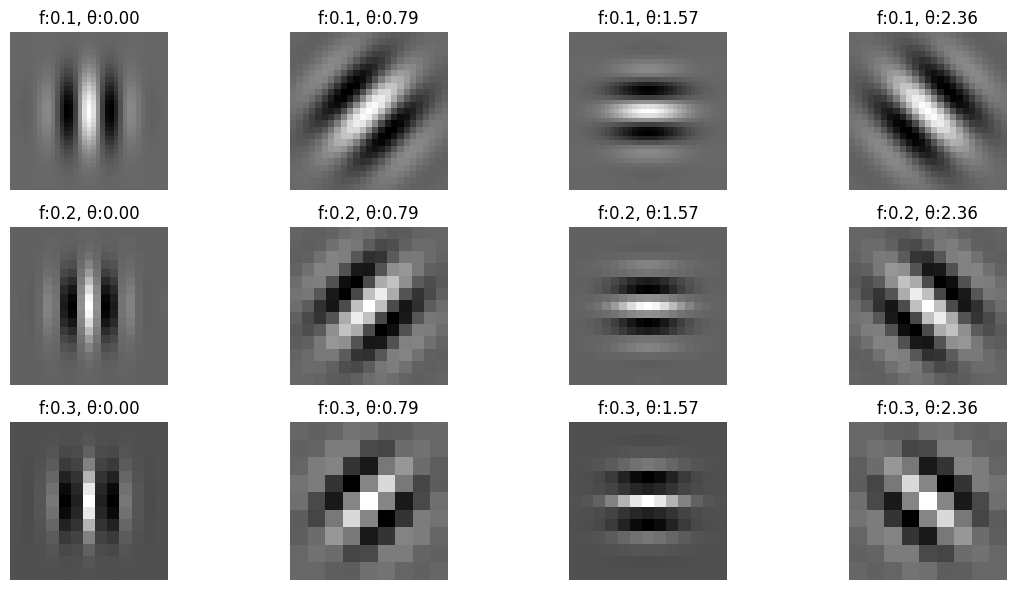

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example parameters
frequencies = [0.1, 0.2, 0.3]
thetas = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
kernel_size = 25
sigma = 4.0
gamma = 0.5

plt.figure(figsize=(12, 6))
i = 1

for f in frequencies:
    wavelength = 1.0 / f
    for t in thetas:
        kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, t, wavelength, gamma, 0, ktype=cv2.CV_32F)
        plt.subplot(len(frequencies), len(thetas), i)
        plt.imshow(kernel, cmap="gray")
        plt.title(f"f:{f}, θ:{t:.2f}")
        plt.axis("off")
        i += 1

plt.tight_layout()
plt.show()
